In [23]:
import cv2
import numpy as np

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show(*images):
    for i in images:
        image = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.show()


# Feature extraction

## Scale Invariant Feature Trasform

It does not depend on rescaling, rotation and small perturbation of brightness.  
The points are drawn where there are changes in the gradient (changes in the image).  
It is a float - providing method.

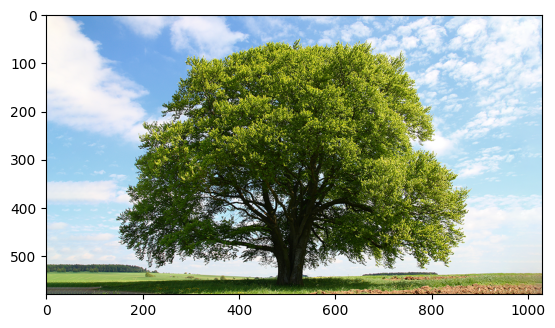

In [25]:
img = cv2.imread("samples/tree.png")
show(img)

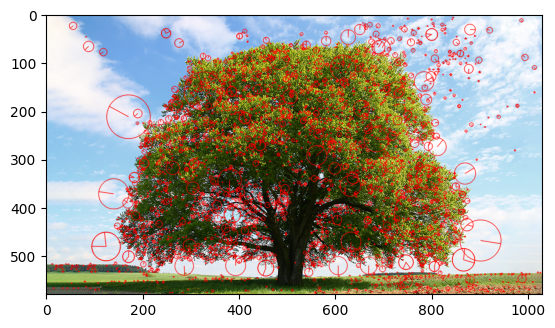

In [26]:
sift = cv2.SIFT.create()
keypoints, descriptors = sift.detectAndCompute(img, None)       #a mask can be specified
cv2.drawKeypoints(img, keypoints, img, (0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#the last flag specifies how much info to keep for keypoints
show(img)

The line inside the circle points towards the direction of the $\nabla_X$.

## SURF

A patented float-descriptor method.

In [27]:
'''
surf = cv2.xfeatures2d.SURF.create()
keypoints, descriptors = surf.detectAndCompute(img, None)       #a mask can be specified
cv2.drawKeypoints(img, keypoints, img, (128, 128, 128), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#the last flag specifies how much info to keep for keypoints
show(img)
'''

'\nsurf = cv2.xfeatures2d.SURF.create()\nkeypoints, descriptors = surf.detectAndCompute(img, None)       #a mask can be specified\ncv2.drawKeypoints(img, keypoints, img, (128, 128, 128), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)\n#the last flag specifies how much info to keep for keypoints\nshow(img)\n'

## A-Kaze

A binary-descriptor method.

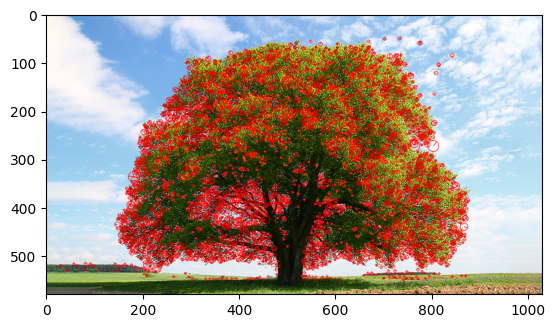

In [28]:
img = cv2.imread("samples/tree.png")
akaze = cv2.AKAZE_create()
keypoints, descriptors = akaze.detectAndCompute(img, None)       #a mask can be specified
cv2.drawKeypoints(img, keypoints, img, (0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#the last flag specifies how much info to keep for keypoints
show(img)

# Panorama

Note that the perspective transform needs *at least* 4 points, but providing more will work just as fine.

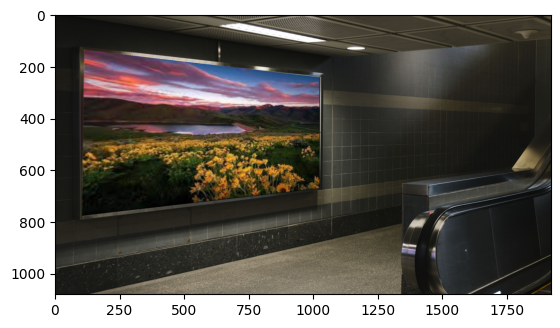

In [36]:
img1 = cv2.imread("samples/landscapebillboard.png")
show(img1)

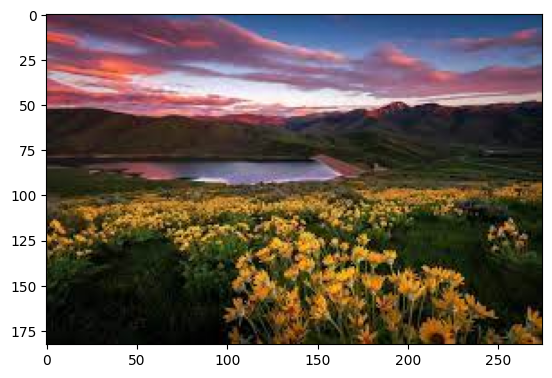

In [35]:
img2 = cv2.imread("samples/landscape.jpeg")
show(img2)

In [38]:
akaze = cv2.AKAZE.create()
kpts1, dscpt1 = akaze.detectAndCompute(img1, None)
kpts2, dscpt2 = akaze.detectAndCompute(img2, None)

The keypoints with the smaller distances should correspond and be the same.  
We compute matches between the two sets of keypoints.

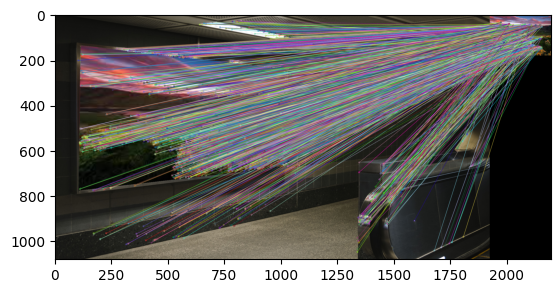

In [39]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING)     #bruteforce matcher
matches = bf.match(dscpt1, dscpt2)

img_matches = cv2.drawMatches(img1, kpts1, img2, kpts2, matches, img2, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)     #we may have keypoints that are not matched with anything
show(img_matches)

Matches can be performed through the *K Nearest Neighbour* algorithm.

In [40]:
img2 = cv2.imread("samples/landscape.jpeg")
bf = cv2.BFMatcher(cv2.NORM_HAMMING)     #bruteforce matcher
matches = bf.knnMatch(dscpt1, dscpt2, k = 2)

img_matches = cv2.drawMatches(img1, kpts1, img2, kpts2, matches, img2, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)     #we may have keypoints that are not matched with anything
show(img_matches)

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'drawMatches'
> Overload resolution failed:
>  - Can't parse 'matches1to2'. Sequence item with index 0 has a wrong type
>  - Can't parse 'matches1to2'. Sequence item with index 0 has a wrong type
>  - drawMatches() missing required argument 'matchesThickness' (pos 7)
>  - drawMatches() missing required argument 'matchesThickness' (pos 7)
